# **Курсовая работа по дисциплине "Автоматика и регулирование ЖРД"**

### Система уравнений

![system.png](img/system.png)

### Исходные данные

In [ ]:
from icecream import ic

p1 = 400e3
p2 = 300e3
p3 = 100e3

k = 1.4
R = 297
p0_gas = 1.2506

c = 1200

p4_0 = 289442.719
Vд_0 = 0

mд_0 = 0
m1_0 = 10.515
m2_0 = 3.249
m3_0 = 13.764

Vж0 = 0.004
ρж = 820


Tгаз0 = 293
ρг = p4_0 / (R * Tгаз0)
Vг0 = 0.001
mгаз = ρг * Vг0

j1 = 400
j2 = 400
j3 = 400
jд = 20

ξ1 = 1000
ξ3 = 1000
ξд = 1000

### Решение СДУ

#### `Решение`

In [ ]:
from scipy.integrate import odeint
import numpy as np
from numpy import pi, sin
import pandas as pd


# Система ОДУ
def system(y, t):
    p4, Vд, mд, m1, m2, m3 = y
    
    d_p4 = (m1 + m2 - m3 - mд) / ((Vж0 + Vд) / c**2)
    d_Vд = mд / ρж
    d_mд = (p4 - (mгаз / (Vг0 - Vд)) * R * (Tгаз0 * ((p4 / p4_0)**((k-1)/k))) - ξд * mд * abs(mд)) / jд
    d_m1 = (p1 - p4 - ξ1 * m1 * abs(m1)) / j1
    d_m2 = (p2 - p4 - ξ2(t) * m2 * abs(m2)) / j2
    d_m3 = (p4 - p3 - ξ3 * m3 * abs(m3)) / j3
    
    return [d_p4, d_Vд, d_mд, d_m1, d_m2, d_m3]

  
def ξ2(t):
    if t <= T/2:
        insin = 2 * pi/T * (t - T/4)
        ξ2 = 1000 + A*(sin(insin) + 1)
    else:
        ξ2 = 1000 + 2*A
    return ξ2


A = 1000
T = 0.1

t_end = 1
h = 1e-6

y0 = [p4_0, Vд_0, mд_0, m1_0, m2_0, m3_0]
t = np.arange(0, t_end, h)

# Решение
sol = odeint(system, y0, t)

# Вывод таблицы значений
# ic(pd.DataFrame(data=sol))

#### `Графики`

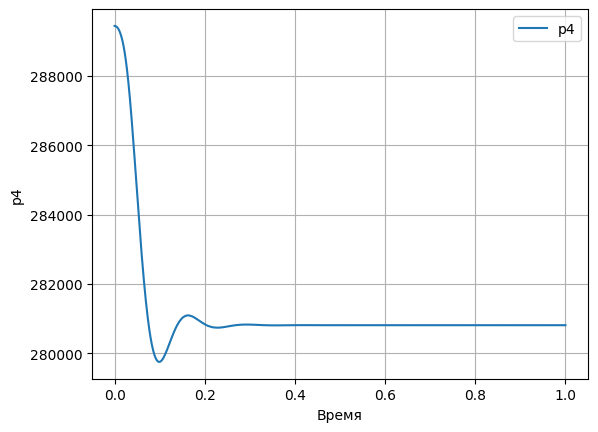

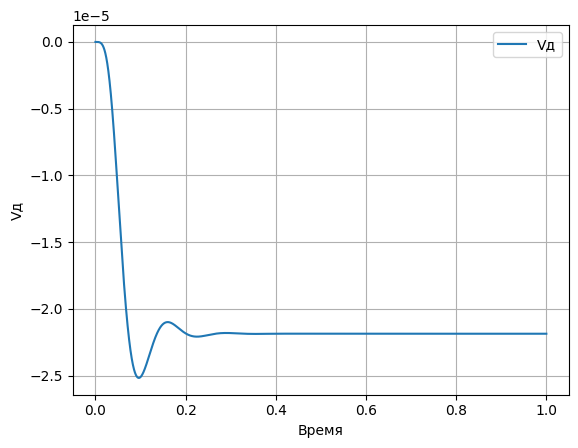

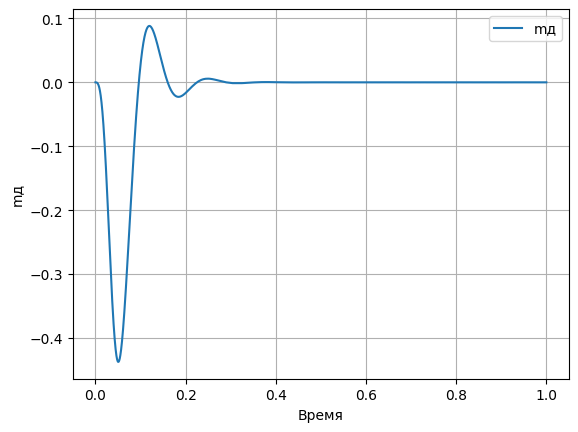

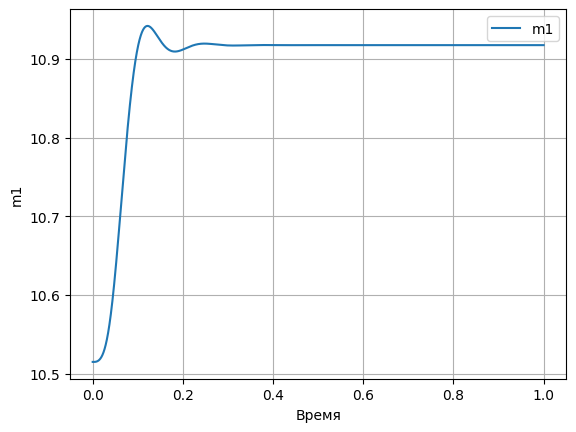

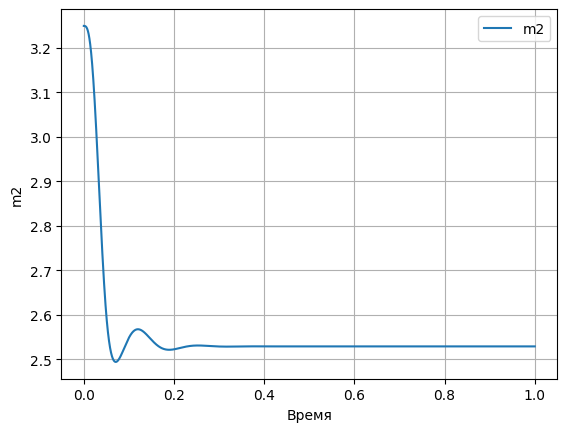

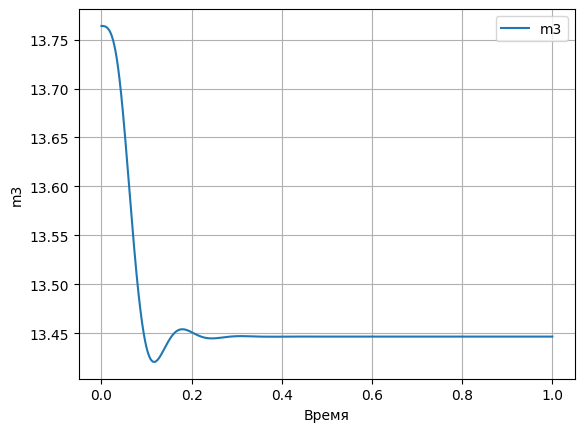

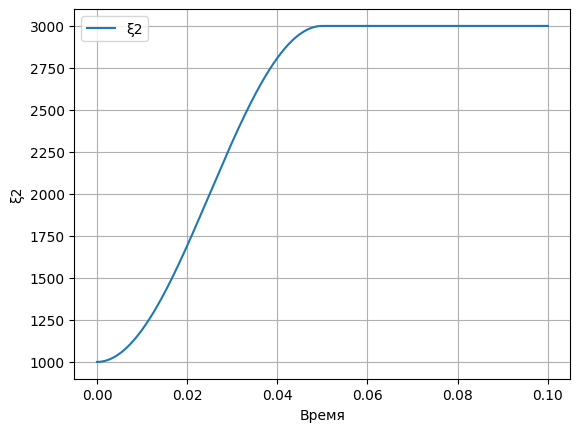

In [ ]:
import matplotlib.pyplot as plt


def plot(t, y, label):
    plt.plot(t, y, label=label)
    plt.grid(True)
    plt.xlabel("Время")
    plt.ylabel(label)
    plt.legend()
    plt.show()


plot(t, sol[:, 0], "p4")
plot(t, sol[:, 1], "Vд")
plot(t, sol[:, 2], "mд")
plot(t, sol[:, 3], "m1")
plot(t, sol[:, 4], "m2")
plot(t, sol[:, 5], "m3")
plot(t[:int(t_end/h/10)], [ξ2(t) for t in t][:int(t_end/h/10)], "ξ2")

### Решение методом Рунге-Кутта

#### `Решение`

In [ ]:
from scipy.integrate import solve_ivp


# Система ОДУ
def system_4rk(t, y):
    p4, Vд, mд, m1, m2, m3 = y
    
    return [(m1 + m2 - m3 - mд) / ((Vж0 + Vд) / c**2),
            mд / ρж,
            (p4 - (mгаз / (Vг0 - Vд)) * R * (Tгаз0 * ((p4 / p4_0)**((k-1)/k))) - ξд * mд * abs(mд)) / jд,
            (p1 - p4 - ξ1 * m1 * abs(m1)) / j1,
            (p2 - p4 - ξ2(t) * m2 * abs(m2)) / j2,
            (p4 - p3 - ξ3 * m3 * abs(m3)) / j3]


t_end = 1
h = 1e-6

y0 = [p4_0, Vд_0, mд_0, m1_0, m2_0, m3_0]

# Решение
# sol_rk = solve_ivp(system_4rk, [0, t_end], y0)
sol_rk = solve_ivp(system_4rk, [0, t_end], y0, max_step=h)

# Таблица значений
sol_rk_df = pd.DataFrame(data=sol_rk.y).transpose()
sol_rk_df.reindex(index=sol_rk.t)
sol_rk_t = pd.DataFrame(data=sol_rk.t).transpose()

# Вывод таблицы значений
# ic(pd.DataFrame(data=sol_rk.y).transpose())
# ic(sol_rk_df)

#### `Графики Рунге-Кутта`

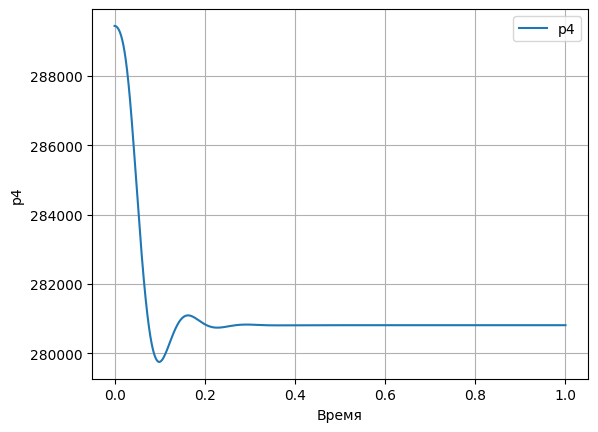

In [ ]:
import matplotlib.pyplot as plt


def plot(t, y, label):
    plt.plot(t, y, label=label)
    plt.grid(True)
    plt.xlabel("Время")
    plt.ylabel(label)
    plt.legend()
    plt.show()


plot(sol_rk.t, sol_rk.y.T[:, 0], "p4")
# plot(t, sol_rk.y[:, 1], "Vд")
# plot(t, sol_rk.y[:, 2], "mд")
# plot(t, sol_rk.y[:, 3], "m1")
# plot(t, sol_rk.y[:, 4], "m2")
# plot(t, sol_rk.y[:, 5], "m3")
# plot(t[:15000], [ξ2(t) for t in t][:15000], "ξ2")

### Построение характеристик

## Memory test

In [ ]:
import sys

In [ ]:
sys.getsizeof(sol)

48000128

In [ ]:
sys.getsizeof(sol_rk)

488

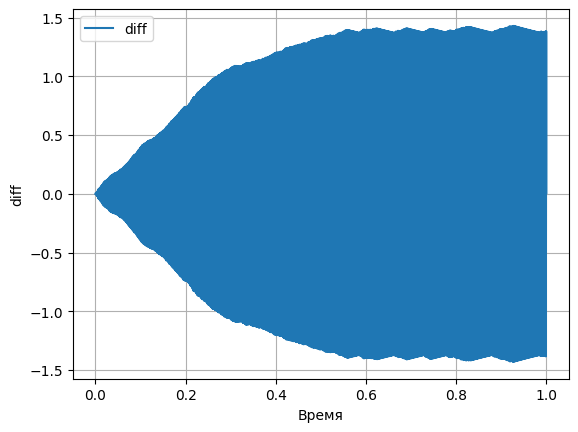

In [ ]:
lsoda = sol[:, 0]
rk = sol_rk.y.T[:, 0]
diff = sol[:, 0] - sol_rk.y.T[:1_000_000, 0]
diff
plot(t[:], diff[:], "diff")
